In [10]:
import sys
from pathlib import Path
sys.executable

import numpy as np
import pandas as pd
# from numpy import cos, sin, pi
# from scipy.optimize import minimize, fmin
import pandas as pd
import os
package_path = '../'
if package_path is not None:
    os.sys.path.append(package_path)

    
import json,yaml
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

import matplotlib
%matplotlib inline
FONT_SIZE = 16

# some setting for the plots
font = {
#     'family' : 'normal',
        'weight' : 'normal',
        'size'   : FONT_SIZE}
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('legend', fontsize=12)
matplotlib.rc('legend', handlelength=2)

# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2


from frozen_dipole_model import frozen_dipole_model, dissipation, thinfilm_superconductor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define functions

In [11]:
def get_parameters(physical_parameters, selector = 'gas'):
    """

    Args:
        physical_parameters: lengths in um
        selector: decide which parameters to pick

    Returns:

    """
    
    if selector =='gas':
        params = {k:v for k, v in physical_parameters.items() if k in ['mgas', 'Tgas', 'mgas', 'density', 'radius', 'Pgas']}
        return params
    elif selector =='jiggle':
        params = {k:v for k, v in physical_parameters.items() 
                    if k in ['Bo', 'magnetic_moment', 'mass', 'levitation_height', 'thickness_SC', 'london_penetration_depth',
                          'eta_bulk', 'vortex_lattice_constant']}
        return params
    
    elif selector =='drag':
        params = {k:v for k, v in physical_parameters.items() 
                    if k in ['frequency', 'levitation_height', 'magnetic_moment', 'mass',
                        'eta_bulk', 'london_penetration_depth', 'thickness_SC', 'temperature', 'vortex_lattice_constant']}
        return params
    
    elif selector =='mag':
        params = {k:v for k, v in physical_parameters.items() 
                    if k in ['density', 'Br', 'chi_m_img', 'levitation_height',
                        'radius', 'frequency']}
        return params

    elif selector == 'sc':
        params = {k:v for k, v in physical_parameters.items() 
                    if k in ['density', 'Br', 'chi_sc_img', 'levitation_height',
                        'radius', 'frequency', 'thickness_SC']}
        
        
        return params

    elif selector == 'disp':
        params = {k:v for k, v in physical_parameters.items() 
                    if k in ['mass', 'Tgas', 'frequency', 'Sdd']}
        
        
        return params


physical_parameters = frozen_dipole_model.default_physical_parameters

get_parameters(physical_parameters, selector = 'disp')

{'Tgas': 4, 'Sdd': 1e-22}

## Plot each contribution individually - damping

### gas damping

Gas damping
$$\gamma_{\rm gas}/ 2 \pi = 0.236 \sqrt{
\frac{m_{gas}}{k_B  T_{gas}}
 }\frac{P_{gas}}{a\rho_{gas}}$$

In [12]:
# params = {k:v for k, v in dissipation.default_physical_parameters.items()
#           if k in ['mgas', 'Tgas', 'mgas', 'density', 'radius']}

# # params['radius'] = 20e-6 #2e-6
# # params['density'] = 2000
# # params['Tgas'] = 300
# params

In [13]:
0.23*np.sqrt(4e-26/1.38e-23)/(7400*20e-6)

0.08366745775228247

In [14]:
params

{'london_penetration_depth': 1e-07, 'thickness_SC': 5e-07, 'eta_bulk': 3.5e-08}

Text(0, 0.5, 'damping $\\gamma/2\\pi$ (Hz)')

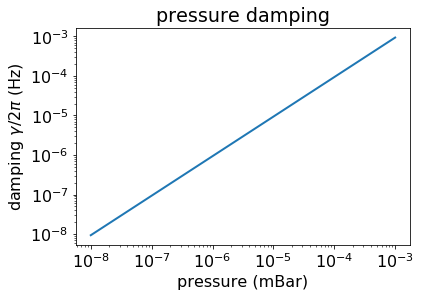

In [15]:
pressure = np.logspace(-8, -3,30)
pressure_Pa = dissipation.millibar_to_pascals(pressure)
params = get_parameters(physical_parameters, selector = 'gas')
params['Pgas']= pressure_Pa
plt.loglog(pressure, dissipation.gas_damping(**params)/(2*np.pi))

plt.xlabel('pressure (mBar)')
plt.title('pressure damping')
plt.ylabel('damping $\gamma/2\pi$ (Hz)')

In [16]:
pressure = 1e-4
pressure_Pa = dissipation.millibar_to_pascals(pressure)
params['Pgas']= pressure_Pa
gamma = dissipation.gas_damping(**params)

Q = 2*np.pi*1e3/gamma
Q*1e-6

10.678936064884546

In [17]:
params

{'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.01,
 'Tgas': 4,
 'mgas': 4.8e-26}

### vortex jiggling

In [18]:

# M = dissipation.calc_magnetic_moment(params['Br'], params['radius'])
# mu0 = dissipation.mu0
# phi0 = dissipation.fluxquantum
# ho = params['levitation_height']
# nv =  M*mu0/(2*np.pi*ho**3*phi0)

# print('vortex lattice constant (nm)', 1/np.sqrt(nv)*1e9)

In [19]:
# # Bo = phio/a^2 = phio nv
# magnetic_moment = dissipation.calc_magnetic_moment(params['Br'], params['radius'])
# print(magnetic_moment)
# nv = dissipation.calc_nv(magnetic_moment, params['radius']*2)
# print('nv (1e12)', nv*1e-12)
# print('a (um)', 1/np.sqrt(nv)*1e6)

In [20]:

# physical_parameters = {k:v for k, v in dissipation.default_physical_parameters.items()
#           if k in ['Br', 'density', 'radius',
#                    'london_penetration_depth', 'thickness_SC',
#                    'london_penetration_depth',
#                    'eta_bulk', 'Tgas'
#                   ]}

physical_parameters = dissipation.default_physical_parameters

def get_parameters_dict_for_damping(physical_parameters, lev_height_factor=2):
    """
    calculate some additional quantities
    
    """
    params = physical_parameters
    params['magnet_orientation']=np.array([1,0,0])
    params['levitation_height']=lev_height_factor*params['radius']
    params['temperature']=params['Tgas']
    params['mass']=dissipation.calc_mass(params['density'], params['radius'])
    params['magnetic_moment']=dissipation.calc_magnetic_moment(params['Br'], params['radius'])*params['magnet_orientation']


    nv = dissipation.calc_nv(params['magnetic_moment'], params['levitation_height'])
    params['vortex_lattice_constant']=1/np.sqrt(nv)

    params['vortex_lattice_constant']=1/np.sqrt(nv)
#     params['frequency'] = frequency  # 1 kHz

    params['Bo']=params['fluxquantum']*nv
    
    return params

get_parameters_dict_for_damping(physical_parameters)

{'Br': 0.73,
 'earth_acceleration': 9.84,
 'vacuum_permeability': 1.2566370614359173e-06,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.001,
 'Tgas': 4,
 'mgas': 4.8e-26,
 'kB': 1.38065e-23,
 'london_penetration_depth': 1e-07,
 'thickness_SC': 5e-07,
 'fluxquantum': 2.0678e-15,
 'eta_bulk': 3.5e-08,
 'hbar': 1.0545718e-34,
 'chi_m_img': 0.01,
 'chi_sc_img': 0.001,
 'Sdd': 1e-22,
 'flux_depth': 1e-07,
 'magnet_orientation': array([1, 0, 0]),
 'levitation_height': 0.00019999999999999998,
 'temperature': 4,
 'mass': 3.112271122156287e-08,
 'magnetic_moment': array([2.43333333e-06, 0.00000000e+00, 0.00000000e+00]),
 'vortex_lattice_constant': 1.843671144122843e-07,
 'Bo': 0.06083333333333333}

In [21]:
physical_parameters

{'Br': 0.73,
 'earth_acceleration': 9.84,
 'vacuum_permeability': 1.2566370614359173e-06,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.001,
 'Tgas': 4,
 'mgas': 4.8e-26,
 'kB': 1.38065e-23,
 'london_penetration_depth': 1e-07,
 'thickness_SC': 5e-07,
 'fluxquantum': 2.0678e-15,
 'eta_bulk': 3.5e-08,
 'hbar': 1.0545718e-34,
 'chi_m_img': 0.01,
 'chi_sc_img': 0.001,
 'Sdd': 1e-22,
 'flux_depth': 1e-07,
 'magnet_orientation': array([1, 0, 0]),
 'levitation_height': 0.00019999999999999998,
 'temperature': 4,
 'mass': 3.112271122156287e-08,
 'magnetic_moment': array([2.43333333e-06, 0.00000000e+00, 0.00000000e+00]),
 'vortex_lattice_constant': 1.843671144122843e-07,
 'Bo': 0.06083333333333333}

In [22]:
params = get_parameters(get_parameters_dict_for_damping(physical_parameters),
                        selector = 'jiggle')

In [23]:



params = get_parameters(get_parameters_dict_for_damping(physical_parameters),
                        selector = 'jiggle')

# gamma = dissipation.vortex_damping_jiggle(
#     **{k:v for k, v in physical_parameters.items() 
#        if k not in ['Br', 'frequency','radius', 'density', 'Tgas', 'magnet_orientation', 'temperature']},
#     verbose=True
# )

gamma = dissipation.vortex_damping_jiggle(
    **params,
    verbose=False
)

print('gamma', gamma)
pd.DataFrame.from_dict(params).iloc[0:1]


gamma [2.33719814e-09 7.79066046e-10 9.34879255e-09]


,london_penetration_depth,thickness_SC,eta_bulk,levitation_height,mass,magnetic_moment,vortex_lattice_constant,Bo
0,1.000000e-07,5.000000e-07,3.500000e-08,0.0002,3.112271e-08,0.000002,1.843671e-07,0.060833


### vortex drag
Damping $\gamma_{drag} = (2\pi)^3  \frac{\pi}{2}  \frac{A_i B_o^2}{m \eta\omega_d^2 a^4\delta^6}$

In [24]:
params = get_parameters(physical_parameters, selector = 'drag')

gamma = dissipation.vortex_damping_drag(**params)

2*np.pi*params['frequency']/gamma*1e-6

TypeError: vortex_damping_drag() missing 1 required positional argument: 'frequency'

In [25]:
print('field fluctuations due to vorteces {:0.2} mT'.format(physical_parameters['Bo']*1e3  ))

field fluctuations due to vorteces 6.1e+01 mT


In [26]:
magnetic_moment = dissipation.calc_magnetic_moment(physical_parameters['Br'], physical_parameters['radius'])
mass = dissipation.calc_mass(physical_parameters['density'], physical_parameters['radius'])
kint = dissipation.calc_kint(params['levitation_height'], dm=100e-9, a=500e-9, magnetic_moment=magnetic_moment)
print('kint (N/m)', kint)
print('particle mass (kg)', mass)
freq_single_vortex = np.sqrt(kint/mass)/ (2*np.pi)
print('freq from interaction with single vortex model (Hz)', freq_single_vortex)
number_vortecies = params['frequency']/freq_single_vortex
print('estimated number of vortecies', number_vortecies)
print('estimated vortex density [1/um^2]', number_vortecies / (np.pi*physical_parameters['radius']**2*1e12))
print('estimated a [um]', 1/np.sqrt(number_vortecies / (np.pi*physical_parameters['radius']**2))*1e6)
nv = dissipation.calc_nv(params['magnetic_moment'], params['levitation_height'])
print('estimated vortex density (nv) [1/um^2]', nv*1e-12)
print('estimated a [um]', 1/np.sqrt(nv)*1e6)

kint (N/m) 1.4985221550794883e-06
particle mass (kg) 3.112271122156287e-08
freq from interaction with single vortex model (Hz) 1.1043659405464714


KeyError: 'frequency'


Damping $\gamma = (2\pi)^3  \frac{\pi}{2}  \frac{A_i B_o^2}{m \eta\omega_d^2 a^4\delta^6}$

In [27]:
dissipation.calc_magnetic_moment(1, 1e-6)

3.3333333333333327e-12

In [28]:
# radius = np.linspace(0.1, 20, 20)*1e-6
# min_dist = thinfilm_superconductor.vortex_creation_minimal_distance(radius=radius)  # minim distance to  create a vortex in mu

In [29]:
# plt.loglog(radius*1e6, min_dist*1e6)

# plt.xlabel('radius (um)')
# plt.ylabel('min distance to create vortex (um)')

In [30]:
default_physical_parameters = frozen_dipole_model.default_physical_parameters
radius = default_physical_parameters['radius']
fluxquantum = default_physical_parameters['fluxquantum']
Br = default_physical_parameters['Br']
vacuum_permeability = default_physical_parameters['vacuum_permeability']
london_penetration_depth = default_physical_parameters['london_penetration_depth']
film_thickness = default_physical_parameters['thickness_SC']

density = default_physical_parameters['density']

L = london_penetration_depth**2 / film_thickness


volume = 4 * np.pi / 3 * radius ** 3
md = Br*volume/vacuum_permeability
mass = density*volume

dm = L
# dm = 0

In [31]:
zo = np.linspace(0.1, 2000, 20)*1e-6
zo = np.logspace(-7, -3, 20)


kint =3 * fluxquantum/ (2*np.pi) * md  / (zo+dm)**4

Text(0, 0.5, 'frequency (Hz)')

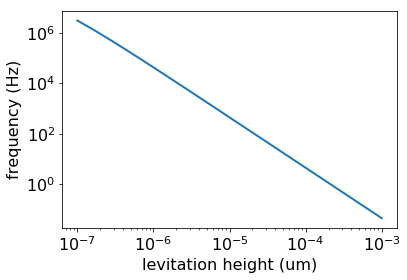

In [32]:
plt.loglog(zo, np.sqrt(kint/mass)/(2*np.pi))
# plt.loglog(zo, 1e-8/zo**2)

plt.xlabel('levitation height (um)')
plt.ylabel('frequency (Hz)')

### magnetic damping - linear response theory

In [33]:

default_physical_parameters = frozen_dipole_model.default_physical_parameters
# dissipation.calc_Qm(mass_density, Br, chi_img, levitation_height, radius, frequency)
params = get_parameters(default_physical_parameters, selector = 'mag')
params['levitation_height'] = 3*params['radius']
params['frequency'] = 2*np.pi*1e3
1e-6*dissipation.calc_Qm(**params)

45.86510943118172

In [34]:
default_physical_parameters

{'Br': 0.73,
 'earth_acceleration': 9.84,
 'vacuum_permeability': 1.2566370614359173e-06,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.001,
 'Tgas': 4,
 'mgas': 4.8e-26,
 'kB': 1.38065e-23,
 'london_penetration_depth': 1e-07,
 'thickness_SC': 5e-07,
 'fluxquantum': 2.0678e-15,
 'eta_bulk': 3.5e-08,
 'hbar': 1.0545718e-34,
 'chi_m_img': 0.01,
 'chi_sc_img': 0.001,
 'Sdd': 1e-22,
 'flux_depth': 1e-07,
 'magnet_orientation': array([1, 0, 0]),
 'levitation_height': 0.00019999999999999998,
 'temperature': 4,
 'mass': 3.112271122156287e-08,
 'magnetic_moment': array([2.43333333e-06, 0.00000000e+00, 0.00000000e+00]),
 'vortex_lattice_constant': 1.843671144122843e-07,
 'Bo': 0.06083333333333333}

In [35]:
params = get_parameters(default_physical_parameters, selector = 'sc')
params['chi_sc_img'] = 0.002
params['levitation_height'] = 3*params['radius']
params['frequency'] = 2*np.pi*1e3
1e-6*dissipation.calc_Qsc(**params)

238.88077828740484

In [36]:
params

{'Br': 0.73,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'thickness_SC': 5e-07,
 'chi_sc_img': 0.002,
 'levitation_height': 0.0003,
 'frequency': 6283.185307179586}

In [37]:
default_physical_parameters = frozen_dipole_model.default_physical_parameters
default_physical_parameters
get_parameters(default_physical_parameters, selector = 'mag')

{'Br': 0.73,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'chi_m_img': 0.01,
 'levitation_height': 0.00019999999999999998}

In [38]:
(2*np.pi*100)**4*1e-4*1e-18 * 1e12

15.585454565440392

In [39]:
params['radius']

9.999999999999999e-05

### displacement noise

In [40]:
default_physical_parameters

{'Br': 0.73,
 'earth_acceleration': 9.84,
 'vacuum_permeability': 1.2566370614359173e-06,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.001,
 'Tgas': 4,
 'mgas': 4.8e-26,
 'kB': 1.38065e-23,
 'london_penetration_depth': 1e-07,
 'thickness_SC': 5e-07,
 'fluxquantum': 2.0678e-15,
 'eta_bulk': 3.5e-08,
 'hbar': 1.0545718e-34,
 'chi_m_img': 0.01,
 'chi_sc_img': 0.001,
 'Sdd': 1e-22,
 'flux_depth': 1e-07,
 'magnet_orientation': array([1, 0, 0]),
 'levitation_height': 0.00019999999999999998,
 'temperature': 4,
 'mass': 3.112271122156287e-08,
 'magnetic_moment': array([2.43333333e-06, 0.00000000e+00, 0.00000000e+00]),
 'vortex_lattice_constant': 1.843671144122843e-07,
 'Bo': 0.06083333333333333}

In [41]:
default_physical_parameters = frozen_dipole_model.default_physical_parameters
# calculate additional parameters
physical_parameters = {**default_physical_parameters, **frozen_dipole_model.get_parameters(default_physical_parameters)}
params = get_parameters(physical_parameters, selector = 'disp')
params['frequency']=1e3
# dissipation.gamma_dissplacement(**params)
# params

In [42]:
physical_parameters

{'Br': 0.73,
 'earth_acceleration': 9.84,
 'vacuum_permeability': 1.2566370614359173e-06,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.001,
 'Tgas': 4,
 'mgas': 4.8e-26,
 'kB': 1.38065e-23,
 'london_penetration_depth': 1e-07,
 'thickness_SC': 5e-07,
 'fluxquantum': 2.0678e-15,
 'eta_bulk': 3.5e-08,
 'hbar': 1.0545718e-34,
 'chi_m_img': 0.01,
 'chi_sc_img': 0.001,
 'Sdd': 1e-22,
 'flux_depth': 1e-07,
 'magnet_orientation': array([1, 0, 0]),
 'levitation_height': 0.00019999999999999998,
 'temperature': 4,
 'mass': 3.112271122156287e-08,
 'magnetic_moment': array([2.43333333e-06, 0.00000000e+00, 0.00000000e+00]),
 'vortex_lattice_constant': 1.843671144122843e-07,
 'Bo': 0.06083333333333333,
 'Us': 2.376323220780444e-10,
 'mass_matrix': array([[3.11227112e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 3.11227112e-08, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3

In [43]:
if 'Tgas' in params:
    del params['Tgas']
params['Q'] = 1e6
dissipation.temperature_dissplacement(**params)*1e-9

87.83210837232279

In [44]:
params

{'Sdd': 1e-22,
 'mass': 3.112271122156287e-08,
 'frequency': 1000.0,
 'Q': 1000000.0}

In [45]:
physical_parameters

{'Br': 0.73,
 'earth_acceleration': 9.84,
 'vacuum_permeability': 1.2566370614359173e-06,
 'radius': 9.999999999999999e-05,
 'density': 7430,
 'Pgas': 0.001,
 'Tgas': 4,
 'mgas': 4.8e-26,
 'kB': 1.38065e-23,
 'london_penetration_depth': 1e-07,
 'thickness_SC': 5e-07,
 'fluxquantum': 2.0678e-15,
 'eta_bulk': 3.5e-08,
 'hbar': 1.0545718e-34,
 'chi_m_img': 0.01,
 'chi_sc_img': 0.001,
 'Sdd': 1e-22,
 'flux_depth': 1e-07,
 'magnet_orientation': array([1, 0, 0]),
 'levitation_height': 0.00019999999999999998,
 'temperature': 4,
 'mass': 3.112271122156287e-08,
 'magnetic_moment': array([2.43333333e-06, 0.00000000e+00, 0.00000000e+00]),
 'vortex_lattice_constant': 1.843671144122843e-07,
 'Bo': 0.06083333333333333,
 'Us': 2.376323220780444e-10,
 'mass_matrix': array([[3.11227112e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 3.11227112e-08, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3

# plot Q-factors

In [46]:
a = np.logspace(-9, -5, 50)

## calculate the frequencies

In [47]:
physical_parameters = frozen_dipole_model.default_physical_parameters
normalization = 'a' # choose normalization z hI or acrit (acrit doesn't work so well because of numerics)

ho = 3 # in units of radius a
to = 0.5 * np.pi
radii = np.logspace(-3,2, 25) # range of radii on a log scale
# ======== end input ========

position_eq, frequencies, eigen_vectors = [], [], []

with tqdm(total=len(radii), file=sys.stdout) as pbar:  
    for i, a in enumerate(radii):
        physical_parameters['radius'] = a*1e-6

        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(i)
        
        parameters = frozen_dipole_model.get_parameters(physical_parameters)

        ret_dict  = frozen_dipole_model.frequencies(ho=ho, to=to, physical_parameters=physical_parameters,
                                                     set_y_phi_zero=True, normalization=normalization)

        frequencies.append(ret_dict['eigenfrequencies'])
        position_eq.append(ret_dict['position_eq'])
        eigen_vectors.append(ret_dict['eigen_vectors'].reshape(-1))

    position_eq = np.array(position_eq)
    frequencies = np.array(frequencies)

processed: 25: : 300it [00:01, 199.85it/s]                   


In [48]:
params = get_parameters(physical_parameters, selector = 'drag')
gamma = dissipation.vortex_damping_drag(**params)

TypeError: vortex_damping_drag() missing 1 required positional argument: 'frequency'

## calculate the damping for all sources of dissipation

In [49]:
gamma_gas = []
Pgas_mBar = 1e-9 ## gas pressure in mBar
mode = 0 # select one of the five eigenmodes
verbose= True
physical_parameters = dissipation.default_physical_parameters

df_dict = {
    'frequency':[],
    'radius':[],
    'gamma_gas':[],
    'gamma_jiggle':[],
    'gamma_drag':[],
    'gamma_mag':[],
    'kint':[],
    'kp':[],
    'a':[],
    'delta':[]
}

for radius, frequency in zip(radii, frequencies):
    frequency = frequency[mode]
    physical_parameters['radius'] = radius*1e-6  # radius is in um, convert to meters    
    physical_parameters['Pgas'] = dissipation.millibar_to_pascals(Pgas_mBar)

    df_dict['frequency'].append(frequency)
    df_dict['radius'].append(radius)
    
    # ============================================================
    ## calculate the dissipation from the viscous vortex theory
    # ============================================================

    for selector, damping in zip(['gas', 'jiggle', 'drag'],
                       [dissipation.gas_damping,
                        dissipation.vortex_damping_jiggle,
                        dissipation.vortex_damping_drag]):
        # calculate additional quantities based off the physical parameters
        params = get_parameters_dict_for_damping(physical_parameters)
        params['frequency'] = frequency
        
        # select the parameters for the dissipation algorithm
        params = get_parameters(params,selector = selector)
        
        
        gamma = damping(**params)
        if selector == 'jiggle':
            gamma = gamma[mode]  # jiggle we get a different damping for each mode
        df_dict['gamma_'+selector].append(gamma)
        
        
    # calculate some additinoal quantities to see how they evolve as a function of radus
    pl = dissipation.calc_pearl_length(params['london_penetration_depth'], params['thickness_SC'])
    kint = dissipation.calc_kint(params['levitation_height'], pl, params['vortex_lattice_constant'],
                                 params['magnetic_moment'])
#         print(len(kint))
    df_dict['kint'].append(kint)
    a = params['vortex_lattice_constant']
    df_dict['a'].append(a)
    
    delta = 2*np.pi * (params['levitation_height']+pl)/a
    df_dict['delta'].append(delta)
    
    kp = dissipation.calc_kp(pl, a)
    df_dict['kp'].append(kp)
    
    # ============================================================
    ## calculate the dissipation from the linear response theory
    # ============================================================
    for selector, damping in zip(['mag'],
                       [dissipation.calc_Qm]):
        # calculate additional quantities based off the physical parameters
        params = get_parameters_dict_for_damping(physical_parameters)
        params['frequency'] = frequency
        
        # select the parameters for the dissipation algorithm
        params = get_parameters(params,selector = selector)
        
        
        Q = damping(**params)
        df_dict['gamma_'+selector].append(2*np.pi*frequency/Q)
        


In [50]:
df = pd.DataFrame.from_dict(df_dict)  # create dataframe
df

,frequency,radius,gamma_gas,gamma_jiggle,gamma_drag,gamma_mag,kint,kp,a,delta
0,1.648986e+07,0.001000,5.883718e-04,1.320079e+00,1.893651e+06,84056.287699,0.000010,0.002503,1.843671e-07,0.749755
1,1.020666e+07,0.001616,3.641821e-04,4.015195e+00,8.184740e+06,52027.965162,0.000035,0.002503,1.843671e-07,0.791713
2,6.317576e+06,0.002610,2.254162e-04,1.034268e+01,2.735253e+07,32203.525602,0.000106,0.002503,1.843671e-07,0.859502
3,3.910365e+06,0.004217,1.395250e-04,2.123805e+01,6.291975e+07,19932.876226,0.000276,0.002503,1.843671e-07,0.969021
4,2.420383e+06,0.006813,8.636118e-05,3.274139e+01,9.018274e+07,12337.763307,0.000594,0.002503,1.843671e-07,1.145960
5,1.498136e+06,0.011007,5.345462e-05,3.628934e+01,7.957663e+07,7636.647842,0.001028,0.002503,1.843671e-07,1.431823
6,9.272959e+05,0.017783,3.308658e-05,2.859569e+01,4.699313e+07,4726.818097,0.001417,0.002503,1.843671e-07,1.893661
7,5.739656e+05,0.028730,2.047946e-05,1.643166e+01,2.066920e+07,2925.733071,0.001583,0.002503,1.843671e-07,2.639807
8,3.552662e+05,0.046416,1.267609e-05,7.253498e+00,7.301174e+06,1810.922947,0.001482,0.002503,1.843671e-07,3.845279
9,2.198988e+05,0.074989,7.846065e-06,2.616778e+00,2.155999e+06,1120.893555,0.001214,0.002503,1.843671e-07,5.792837


In [51]:
kp/(pl*default_physical_parameters['eta_bulk'])*1e-9

3575.0510664815115

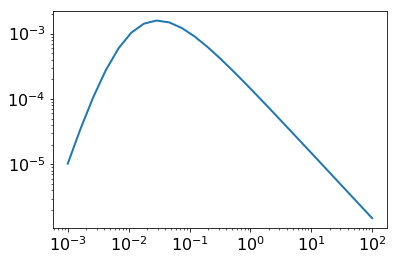

In [52]:
plt.loglog(df.radius, df.kint)

In [53]:

dissipation.calc_pearl_length(frozen_dipole_model.default_physical_parameters['london_penetration_depth'], frozen_dipole_model.default_physical_parameters['thickness_SC'])

1.9999999999999997e-08

Text(0, 0.5, 'Q')

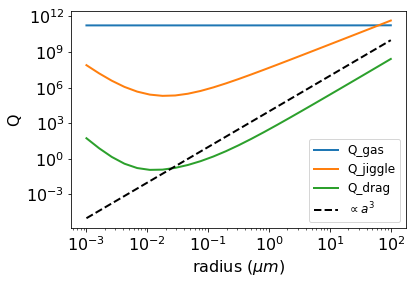

In [54]:

# caculate the Q-factors
df['Q_gas'] =2*np.pi*df['frequency'] / df['gamma_gas']
df['Q_jiggle'] =2*np.pi*df['frequency'] / df['gamma_jiggle']
df['Q_drag'] =2*np.pi*df['frequency'] / df['gamma_drag']

for Q_label in ['Q_gas', 'Q_jiggle', 'Q_drag']:
    plt.loglog(df['radius'], df[Q_label], label = Q_label)
    
plt.plot(df['radius'], 1e4*df['radius']**3, 'k--', label = '$\propto a^3$')
plt.legend()
plt.xlabel('radius ($\mu m$)')
plt.ylabel('Q')

# plot for paper

In [55]:
paper_fig_path = Path('/Users/rettentulla/Projects/Paper/InProgress/MagneticLevitation/manuscript/figures/')

## Q factors with viscous vortex model

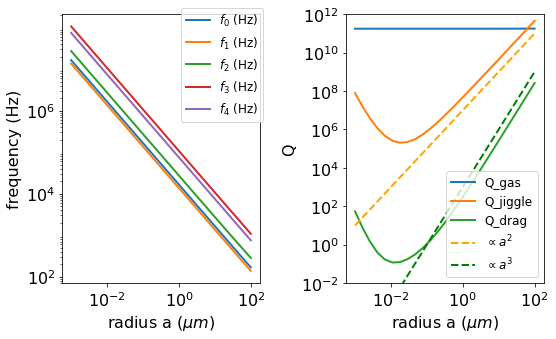

In [56]:
fig, ax = plt.subplots(1,2, figsize= (8,5))
for i, f in enumerate(frequencies.T):

    ax[0].loglog(radii, f, label = '$f_{:d}$ (Hz)'.format(i))
ax[0].set_xlabel('radius a ($\mu m$)')
ax[0].set_ylabel('frequency (Hz)')
# plt.title('initial conditions ho={:0.1f}a, to={:0.0f}deg'.format(ho, to/np.pi*180))
# ax[0].set_xticks([0.001, 0.01, 0.1, 1, 10, 100])
ax[0].set_xticks([0.01, 1, 100])
ax[0].set_yticks([1e2, 1e4, 1e6])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[0].legend(loc = (0.6, 0.6))



# caculate the Q-factors
df['Q_gas'] =2*np.pi*df['frequency'] / df['gamma_gas']
df['Q_jiggle'] =2*np.pi*df['frequency'] / df['gamma_jiggle']
df['Q_drag'] =2*np.pi*df['frequency'] / df['gamma_drag']

for Q_label in ['Q_gas', 'Q_jiggle', 'Q_drag']:
    ax[1].loglog(df['radius'], df[Q_label], label = Q_label)
ax[1].plot(df['radius'], 1e7*df['radius']**2, '--',color='orange', label = '$\propto a^2$')
ax[1].plot(df['radius'], 1e3*df['radius']**3, '--', color='green', label = '$\propto a^3$')
ax[1].legend()
ax[1].set_xlabel('radius a ($\mu m$)')
ax[1].set_ylabel('Q')
ax[1].set_ylim([1e-2,1e12])
# 
plt.tight_layout()
fig.savefig(paper_fig_path/'damping.pdf', transparent=True)

In [60]:
frequencies.T[2]

array([2.72706662e+07, 1.68796131e+07, 1.04479083e+07, 6.46690215e+06,
       4.00279567e+06, 2.47759812e+06, 1.53355294e+06, 9.49221152e+05,
       5.87539789e+05, 3.63671411e+05, 2.25104528e+05, 1.39336365e+05,
       8.62487991e+04, 5.33894118e+04, 3.30505717e+04, 2.04615253e+04,
       1.26693346e+04, 7.84623270e+03, 4.86089381e+03, 3.01306508e+03,
       1.86931323e+03, 1.16135518e+03, 7.23129798e+02, 4.51846241e+02,
       2.83873318e+02])

## frequencies and couplings

### calclate the frequencies

In [62]:
radii

array([1.00000000e-03, 1.61559810e-03, 2.61015722e-03, 4.21696503e-03,
       6.81292069e-03, 1.10069417e-02, 1.77827941e-02, 2.87298483e-02,
       4.64158883e-02, 7.49894209e-02, 1.21152766e-01, 1.95734178e-01,
       3.16227766e-01, 5.10896977e-01, 8.25404185e-01, 1.33352143e+00,
       2.15443469e+00, 3.48070059e+00, 5.62341325e+00, 9.08517576e+00,
       1.46779927e+01, 2.37137371e+01, 3.83118685e+01, 6.18965819e+01,
       1.00000000e+02])

In [63]:
physical_parameters = frozen_dipole_model.default_physical_parameters
normalization = 'a' # choose normalization z hI or acrit (acrit doesn't work so well because of numerics)

ho = 3 # in units of radius a
to = 0.5 * np.pi
radii = np.logspace(-1,2, 25) # range of radii on a log scale
# ======== end input ========

position_eq, frequencies, eigen_vectors = [], [], []

with tqdm(total=len(radii), file=sys.stdout) as pbar:  
    for i, a in enumerate(radii):
        physical_parameters['radius'] = a*1e-6

        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(i)
        
        parameters = frozen_dipole_model.get_parameters(physical_parameters)

        ret_dict  = frozen_dipole_model.frequencies(ho=ho, to=to, physical_parameters=physical_parameters,
                                                     set_y_phi_zero=True, normalization=normalization)

        frequencies.append(ret_dict['eigenfrequencies'])
        position_eq.append(ret_dict['position_eq'])
        eigen_vectors.append(ret_dict['eigen_vectors'].reshape(-1))

    position_eq = np.array(position_eq)
    frequencies = np.array(frequencies)

processed: 25: : 300it [00:02, 145.18it/s]                   


### calculate the couplings

dipole coupling (1um radius) [2.57236850e+01 2.49395026e+01 2.27559729e+01 1.96111239e+01
 1.60483366e+01 1.25507417e+01 9.44447043e+00 6.88380499e+00
 4.88928230e+00 3.40181427e+00 2.32885568e+00 1.57437398e+00
 1.05404804e+00 7.00466833e-01 4.62868744e-01 3.04553619e-01
 1.99737242e-01 1.30674056e-01 8.53330052e-02 5.56468400e-02
 3.62501319e-02 2.35959357e-02 1.53499985e-02 9.98129528e-03
 6.48815082e-03]
gradient coupling (1um radius) in kHz [7.10254827e+00 6.81533175e+00 6.03157171e+00 4.94659775e+00
 3.78625609e+00 2.72811374e+00 1.86726848e+00 1.22482684e+00
 7.76181766e-01 4.78539086e-01 2.88730981e-01 1.71309122e-01
 1.00334546e-01 5.81862077e-02 3.34898928e-02 1.91655654e-02
 1.09206549e-02 6.20234303e-03 3.51392649e-03 1.98711939e-03
 1.12214610e-03 6.33023096e-04 3.56818803e-04 2.01010691e-04
 1.13187343e-04]


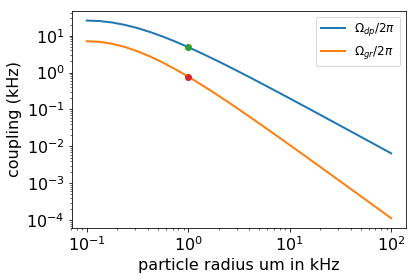

In [72]:
hbar = 1.05e-34
mu0 = 4*np.pi*1e-7
Br = 0.7 # Tesla
rho = 7430 # kg/m^3
gamma0 =  2 *np.pi * 28.024e9 # Hertz/Tesla
# eta = 1/3 #that's the optimal distance for gradient coupling
gap = 100e-9 # gap between magnet and NV

radius = radii*1e-6

# def coupling_dipole(magnetic_moment, r):
def coupling_dipole(radius):
    Volume = 4*np.pi/3*radius**3
    magnetic_moment = Br*Volume / mu0
    mass = rho*Volume
#     r = (eta+1)*radius
    r = radius+gap
    omega0 = 2*np.pi*alpha/radius
    return np.sqrt(2*magnetic_moment*hbar*gamma0)*gamma0*mu0/(16*np.pi*r**3)



def coupling_gradient(radius):
    Volume = 4*np.pi/3*radius**3
    magnetic_moment = Br*Volume / mu0
    mass = rho*Volume
#     r = (eta+1)*radius
    r = radius+gap
    omega0 = 2*np.pi*alpha/radius
    rzp = np.sqrt(hbar / (2*mass*omega0))
    return 3*rzp*gamma0*mu0*magnetic_moment/(8*np.pi*r**4)

plt.loglog(radius*1e6, 1e-3*coupling_dipole(radius)/(2*np.pi), label = '$\Omega_{dp}/2\pi$')
plt.loglog(radius*1e6, 1e-3*coupling_gradient(radius)/(2*np.pi), label = '$\Omega_{gr}/2\pi$')

radius_0 = 1e-6
plt.loglog(radius_0*1e6, 1e-3*coupling_dipole(radius_0)/(2*np.pi),'o')
print('dipole coupling (1um radius)', 1e-3*coupling_dipole(radius)/(2*np.pi))
plt.loglog(radius_0*1e6, 1e-3*coupling_gradient(radius_0)/(2*np.pi),'o')
print('gradient coupling (1um radius) in kHz', 1e-3*coupling_gradient(radius)/(2*np.pi))
plt.xlabel('particle radius um in kHz')
plt.ylabel('coupling (kHz)')
plt.legend()

### plot frequency and coupling

dipole coupling (1um radius) [2.57236850e+01 2.49395026e+01 2.27559729e+01 1.96111239e+01
 1.60483366e+01 1.25507417e+01 9.44447043e+00 6.88380499e+00
 4.88928230e+00 3.40181427e+00 2.32885568e+00 1.57437398e+00
 1.05404804e+00 7.00466833e-01 4.62868744e-01 3.04553619e-01
 1.99737242e-01 1.30674056e-01 8.53330052e-02 5.56468400e-02
 3.62501319e-02 2.35959357e-02 1.53499985e-02 9.98129528e-03
 6.48815082e-03]
gradient coupling (1um radius) in kHz [7.10254827e+00 6.81533175e+00 6.03157171e+00 4.94659775e+00
 3.78625609e+00 2.72811374e+00 1.86726848e+00 1.22482684e+00
 7.76181766e-01 4.78539086e-01 2.88730981e-01 1.71309122e-01
 1.00334546e-01 5.81862077e-02 3.34898928e-02 1.91655654e-02
 1.09206549e-02 6.20234303e-03 3.51392649e-03 1.98711939e-03
 1.12214610e-03 6.33023096e-04 3.56818803e-04 2.01010691e-04
 1.13187343e-04]


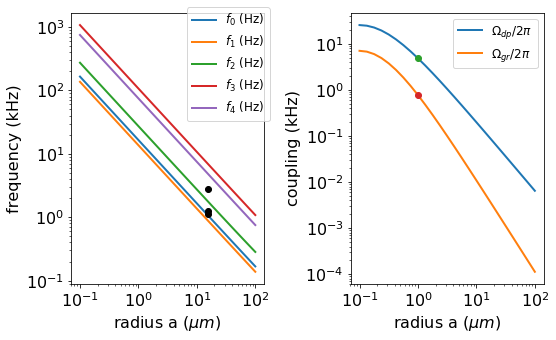

In [85]:
fig, ax = plt.subplots(1,2, figsize= (8,5))
for i, f in enumerate(frequencies.T):

    ax[0].loglog(radii, 1e-3*f, label = '$f_{:d}$ (Hz)'.format(i))
    
# plot particle 2 frequencies
a = 11
a = 15.5
for freq in [1133.0,1232.0,2815.0]:
    ax[0].plot(a, 1e-3*freq, 'ok')
ax[0].set_xlabel('radius a ($\mu m$)')
ax[0].set_ylabel('frequency (kHz)')
# plt.title('initial conditions ho={:0.1f}a, to={:0.0f}deg'.format(ho, to/np.pi*180))
# ax[0].set_xticks([0.001, 0.01, 0.1, 1, 10, 100])
ax[0].set_xticks([0.1, 1, 10, 100])
ax[0].set_yticks([1e-1, 1e0, 1e1, 1e2, 1e3])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[0].legend(loc = (0.6, 0.6))




ax[1].loglog(radius*1e6, 1e-3*coupling_dipole(radius)/(2*np.pi), label = '$\Omega_{dp}/2\pi$')
ax[1].loglog(radius*1e6, 1e-3*coupling_gradient(radius)/(2*np.pi), label = '$\Omega_{gr}/2\pi$')

radius_0 = 1e-6
ax[1].loglog(radius_0*1e6, 1e-3*coupling_dipole(radius_0)/(2*np.pi),'o')
print('dipole coupling (1um radius)', 1e-3*coupling_dipole(radius)/(2*np.pi))
ax[1].loglog(radius_0*1e6, 1e-3*coupling_gradient(radius_0)/(2*np.pi),'o')
print('gradient coupling (1um radius) in kHz', 1e-3*coupling_gradient(radius)/(2*np.pi))
ax[1].set_xlabel('radius a ($\mu m$)')
ax[1].set_ylabel('coupling (kHz)')
ax[1].legend()

# 
plt.tight_layout()
fig.savefig(paper_fig_path/'couplings.pdf', transparent=True)